In [1]:
import akshare as ak
import pandas as pd
import numpy as np
import talib
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 云哥的一些需求

请构建一个量化交易分析模型
1. 请做一个右侧趋势的预测，比如5日线 20日线不破
2. 日K KDJ的J值-1~-5 接下来5日 10日 和20日交易日的涨幅

以最近的沪深300数据为数据集，构建分析模型

# 一些操作

1. Ta-Lib

TaLib是一个Python金融指数处理库。包含了很多技术分析里的常用参数指标，例如MA、SMA、WMA、MACD、ATR等。

```
conda install -c conda-forge ta-lib  
```


## 检查指数代码

In [2]:
# 查看指数列表
index_list = ak.index_stock_info()
print(index_list)

    index_code display_name publish_date
0       000001         上证指数   1991-07-15
1       000002         A股指数   1992-02-21
2       000003         B股指数   1992-02-21
3       000004         工业指数   1993-05-03
4       000005         商业指数   1993-05-03
..         ...          ...          ...
720     399994   中证信息安全主题指数   2015-03-12
721     399995     中证基建工程指数   2015-03-12
722     399996     中证智能家居指数   2014-09-17
723     399997       中证白酒指数   2015-01-21
724     399998       中证煤炭指数   2015-02-13

[725 rows x 3 columns]


In [3]:
hs300_info = index_list[index_list["display_name"].str.contains('沪深300|HS300')]

In [4]:
hs300_info

,index_code,display_name,publish_date
143,000300,沪深300,2005-04-08
203,000849,沪深300非银行金融指数,2012-12-21
204,000850,沪深300有色金属指数,2012-12-21
387,399300,沪深300,2005-04-08
639,399908,沪深300能源指数,2007-07-02
640,399909,沪深300原材料指数,2007-07-02
641,399910,沪深300工业指数,2007-07-02
642,399911,沪深300可选消费指数,2007-07-02
643,399912,沪深300主要消费指数,2007-07-02
644,399913,沪深300医药卫生指数,2007-07-02


In [5]:
type(hs300_info)

pandas.core.frame.DataFrame

## 沪深300数据

In [16]:
# 获取沪深300数据
data = ak.index_zh_a_hist(symbol="000300", period="daily", start_date="2020-01-01", end_date="2025-01-01")
data['date'] = pd.to_datetime(data['日期'])
data.set_index('date', inplace=True)
data = data[['收盘', '最高', '最低', '开盘', '成交量']]
data.columns = ['close', 'high', 'low', 'open', 'volume']

In [17]:
"""计算均线"""
data['MA5'] = talib.SMA(data['close'], timeperiod=5)
data['MA20'] = talib.SMA(data['close'], timeperiod=20)

In [18]:
"""计算KDJ指标"""
high, low, close = data['high'], data['low'], data['close']
kdj_k, kdj_d = talib.STOCH(high, low, close, fastk_period=9, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
kdj_j = 3 * kdj_k - 2 * kdj_d
data['J'] = kdj_j

In [19]:
"""标签: 未来5日、10日、20日涨幅"""
data['return_5d'] = data['close'].pct_change(5).shift(-5)
data['return_10d'] = data['close'].pct_change(10).shift(-10)
data['return_20d'] = data['close'].pct_change(20).shift(-20)

In [20]:
"""特征"""
data['ma_crossover'] = (data['MA5'] > data['MA20']).astype(int)
data['J_signal'] = ((data['J'] > -5) & (data['J'] < -1)).astype(int)

In [21]:
"""特征集"""
features = data[['ma_crossover', 'J_signal', 'J']]
target = data[['return_5d', 'return_10d', 'return_20d']]

In [22]:
data_combined = pd.concat([features, target], axis=1).dropna()

In [23]:
features = data_combined[['ma_crossover', 'J_signal', 'J']]
target = data_combined[['return_5d', 'return_10d', 'return_20d']]


均方误差: 0.0010515369330552217


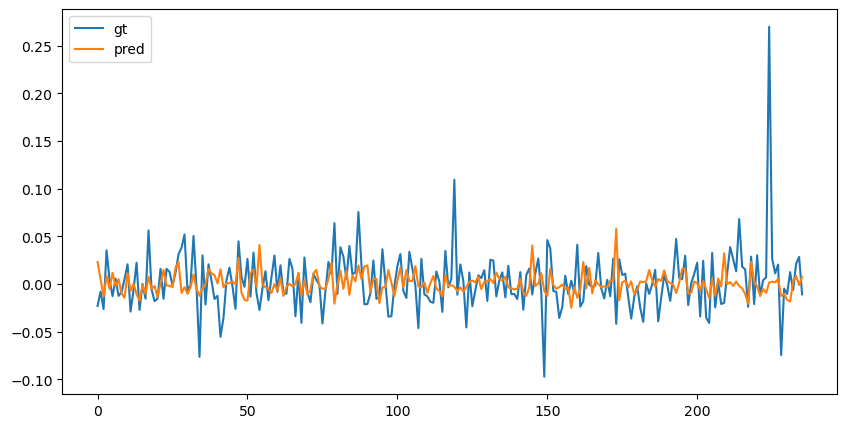

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features, target['return_5d'], test_size=0.2, random_state=42)

model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("均方误差:", mse)

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="gt")
plt.plot(predictions, label="pred")
plt.legend()
plt.show()
